All the functions are here so you can see how they're working 


In [2]:
!pip install yfinance
!pip install -q pyyaml h5py  # Required to save models in HDF5 format
!pip install cpi


     |████████████████████████████████| 5.5MB 10.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=be2f4c72097024464b68be9b758885c997350819c82f622036c992be40a09a71
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 25.5MB 119kB/s 


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import altair as alt
from matplotlib import pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Concatenate
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Dropout
from keras.callbacks import Callback
from keras.regularizers import l2

import cpi
cpi.update()

/usr/local/lib/python3.7/dist-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# allows us to see everything
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# modified combiner function
def combine_histories(stock_dfs):
    ## This function combines multiple stock dfs and sorts them by date
    combine_df = None

    for key in stock_dfs:
        #print(key)
        if combine_df is not None:
            combine_df = pd.concat([combine_df, stock_dfs[key]])
        else:
            combine_df = stock_dfs[key] # get the first one

    combine_df.sort_values(by=['Date'], inplace=True)
    return combine_df

# Kelvin 26/02/21: Daily average (mean of daily open, close, high, low )
# append all preprocessed data that could possibly be of use
def prep_lstm_stock(stock_df, name):
   
    #####################
    ##### YFIN DATA #####
    #####################
    nan_idxs = stock_df.isnull().any(1).to_numpy().nonzero()[0]

    #print("Rows with NaN: ", nan_idxs) # bool

    for i in nan_idxs: # list of row indices
      #print(stock_df.iloc[i])
      nan_close = stock_df.iloc[i-1]['Close']
      stock_df.iloc[i] = {'Open': nan_close, 'Close': nan_close, 'High': nan_close, 'Low':nan_close, 'Volume':0}
      #print(stock_df.iloc[i])
    #print(stock_df.iloc[i])

    stock_df['Close'] = stock_df.apply(lambda x: cpi.inflate(x['Close'], x.name.year ) if x.name.year < 2019 else x['Close'] ,axis=1) # adjust for inflation 
    stock_df['Prev Close'] = stock_df['Close'].shift(1, fill_value=1) # store close price of prev day


    stock_df['Price'] = stock_df[['High', 'Low', 'Open', 'Close']].mean(axis=1)
    stock_df['Variance'] = stock_df[['High', 'Low', 'Open', 'Close']].var(axis=1)
    stock_df['Stock'] = pd.DataFrame(index=stock_df.index, columns=['Stock']).fillna(name)

    stock_df['Return'] = (stock_df['Close'] - stock_df['Close'].shift(1, fill_value=0)) / stock_df['Close'].shift(1, fill_value=1) # get return
    stock_df['Return'].iloc[0] = 0 # change first gradient value to 0 

    stock_df['Return MA5'] = stock_df['Return'].rolling(5, min_periods=1).mean()
    stock_df['Return MA10'] = stock_df['Return'].rolling(10, min_periods=1).mean()
    stock_df['Return MA20'] = stock_df['Return'].rolling(20, min_periods=1).mean()
    stock_df['Std Return MA5'] = (stock_df['Return MA5']-stock_df['Return MA5'].mean())/stock_df['Return MA5'].std()
    stock_df['Std Return MA10'] = (stock_df['Return MA10']-stock_df['Return MA10'].mean())/stock_df['Return MA10'].std()
    stock_df['Std Return MA20'] = (stock_df['Return MA20']-stock_df['Return MA20'].mean())/stock_df['Return MA20'].std()

    stock_df['Std Return'] = (stock_df['Return']-stock_df['Return'].mean())/stock_df['Return'].std() # using standardization
    #stock_df['Std Return MA5'] = stock_df['Std Return'].rolling(5, min_periods=1).mean()
    #stock_df['Std Return MA10'] = stock_df['Std Return'].rolling(10, min_periods=1).mean()
    #stock_df['Std Return MA20'] = stock_df['Std Return'].rolling(20, min_periods=1).mean()

    # mean standardization
    #normalized_df=(df-df.mean())/df.std()

    # min max normalization
    #normalized_df=(df-df.min())/(df.max()-df.min())

    stock_df['Volume Grad'] = (stock_df['Volume'] - stock_df['Volume'].shift(1, fill_value=0))
    stock_df['Volume Grad'].iloc[0] = 0 # change first gradient value to 0 
    stock_df['Std Volume Grad'] = (stock_df['Volume Grad']-stock_df['Volume Grad'].mean())/stock_df['Volume Grad'].std() # using standardization
    stock_df['Std Volume Grad'] = stock_df.apply(lambda x: 0 if x['Volume Grad'] == 0 else x['Std Volume Grad'], axis=1) # if NaN its because its an index that doesnt have volume : set to 0 

    ##########################
    ##### SENTIMENT DATA #####
    ##########################
    """
    # r/investing
    reddit_investing = pd.read_csv('/content/drive/MyDrive/SENG474_Project/data/sentiment/investing_'+name+'_sentiment.csv')#.set_index('date', inplace=True) # .merge(stock_df, how='left', left_index=True, right_index=True).fillna(0, inplace=True)
    reddit_investing.set_index('date', inplace=True)
    print("R INVESTING: \n", reddit_investing.tail(100))

    # r/stocks
    reddit_stocks = pd.read_csv('/content/drive/MyDrive/SENG474_Project/data/sentiment/stocks_'+name+'_sentiment.csv')#.set_index('date', inplace=True)
    reddit_stocks.set_index('date', inplace=True)
    print("R STOCKS: \n", reddit_stocks.tail(100))
    """
    #numposts , compoundMean most important


    stock_df = stock_df.drop(['High', 'Low', 'Open', 'Stock Splits', 'Dividends'], axis=1, errors='ignore') # drop these for now
    
    stock_df = stock_df[stock_df.index != '2001-09-12']  # LEAVE THIS: deletes september 11th 2001 from data
    #if name=="KO":
    #print("STOCK DF %s\n %s" % (name, stock_df.tail(100)))
    # Working up to here
    #pd.set_option("display.max_rows", None, "display.max_columns", None)
    return stock_df



In [6]:
print(prep_lstm_stock(yf.Ticker('^VIX').history(period='max'), '^VIX'))

                Close  Volume  Prev Close      Price   Variance Stock    Return  Return MA5  Return MA10  Return MA20  Std Return MA5  Std Return MA10  Std Return MA20  Std Return  Volume Grad  Std Volume Grad
Date                                                                                                                                                                                                             
1990-01-02  34.138497       0    1.000000  21.464624  71.389804  ^VIX  0.000000    0.000000     0.000000     0.000000       -0.079418        -0.124235        -0.187916   -0.031504            0                0
1990-01-03  36.019680       0   34.138497  22.647421  79.474371  ^VIX  0.055104    0.027552     0.027552     0.027552        0.913550         1.417444         2.116332    0.757846            0                0
1990-01-04  38.059275       0   36.019680  23.929818  88.729577  ^VIX  0.056624    0.037243     0.037243     0.037243        1.262799         1.959687         2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
#stock_list = ['AMZN','AAPL', 'FB', 'MSFT','TSLA', 'GOOG']
stock_list = ['KO','AMZN', 'AAPL', 'FB','GOOGL', 'MSFT', 'TSLA', 'XOM', 'GE', 'IBM', 'MO', 'JNJ','GM', 'CVX','WMT', 'PG', 'BRK-A', 'BRK-B', '^VIX', 'WFC']
#more = ['DWDP', DD, 'MRK',  'INTC', 'JPM', 'HD', 'PEP','PCG', 'FSLR', 'MUR', 'MOS', 'DVN', 'MRO', 'FLR', 'EQT', 'RRC', 'RIG', 'CHK', 'DPZ', 'ULTA', 'SLV', 'GME', 'AMC', '^VXN', '^DJI', ,'^IXIC']
# including best and worst stocks from 11 years: https://www.kiplinger.com/slideshow/investing/t052-s001-11-best-and-11-worst-stocks-11-year-bull-market/index.html
stock_dfs = {} # get stocks from yf and store prepped version
for stock in stock_list:
    stock_dfs[stock] = prep_lstm_stock(yf.Ticker(stock).history(period='max'), stock)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

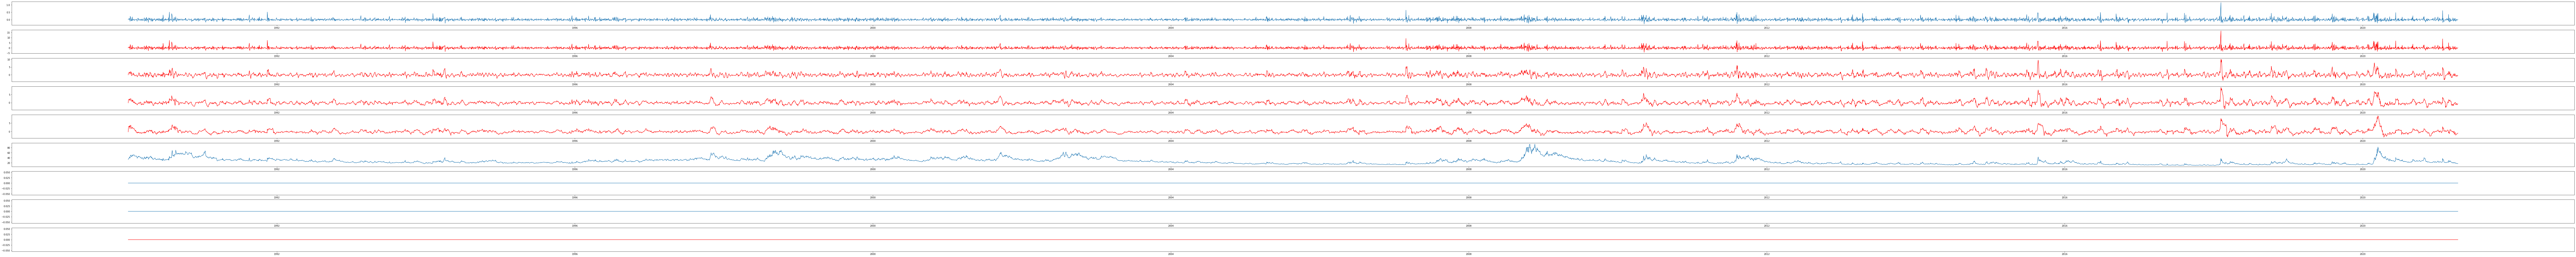

In [7]:
cumulative_df = combine_histories(stock_dfs)
#print(cumulative_df.head(50))
#print(cumulative_df.tail(50))
#print(cumulative_df)

# TESTING: EXAMPLE OF STOCK DATA
fig, axs = plt.subplots(9, figsize=(200,20))

test_stock = '^VIX'
axs[0].plot(cumulative_df[cumulative_df['Stock']==test_stock]['Return'])
axs[1].plot(cumulative_df[cumulative_df['Stock']==test_stock]['Std Return'], 'r')
axs[2].plot(cumulative_df[cumulative_df['Stock']==test_stock]['Std Return MA5'], 'r')
axs[3].plot(cumulative_df[cumulative_df['Stock']==test_stock]['Std Return MA10'], 'r')
axs[4].plot(cumulative_df[cumulative_df['Stock']==test_stock]['Std Return MA20'], 'r')
axs[5].plot(cumulative_df[cumulative_df['Stock']==test_stock]['Close'])
axs[6].plot(cumulative_df[cumulative_df['Stock']==test_stock]['Volume'])
axs[7].plot(cumulative_df[cumulative_df['Stock']==test_stock]['Volume Grad'])
axs[8].plot(cumulative_df[cumulative_df['Stock']==test_stock]['Std Volume Grad'], 'r')

timesteps = 10

In [8]:
# what we want is, for every new stock(s) added to dataset, create a history that spans the entire stock history.
# AAPL joins in 1980: we get a stock history dataset that contains all stocks being tracked from period 1980-2021
stocks_per_date = pd.DataFrame(cumulative_df.index.value_counts(), columns=["Date"]) # count the number of stocks active at any given date; use this to partition into histories
cumulative_df = cumulative_df.join(stocks_per_date) 
print(cumulative_df.head(20))
print(cumulative_df.tail(20))


                Close     Volume  Prev Close     Price   Variance Stock    Return  Return MA5  Return MA10  Return MA20  Std Return MA5  Std Return MA10  Std Return MA20  Std Return  Volume Grad  Std Volume Grad  Date
1962-01-02   0.431809   806400.0    1.000000  0.147255   0.035988    KO  0.000000    0.000000     0.000000     0.000000       -0.066537        -0.097599        -0.141249   -0.029112          0.0         0.000000     8
1962-01-02  15.450917   390000.0    1.000000  5.266969  46.094675   IBM  0.000000    0.000000     0.000000     0.000000       -0.039270        -0.055950        -0.077599   -0.017083          0.0         0.000000     8
1962-01-02   0.577771        0.0    1.000000  0.179096   0.071708   JNJ  0.000000    0.000000     0.000000     0.000000       -0.074659        -0.109828        -0.159409   -0.032816          0.0         0.000000     8
1962-01-02   0.029254   345600.0    1.000000  0.009085   0.000184    MO  0.000000    0.000000     0.000000     0.000000       -0

In [9]:
# We have to combine multiple keras models. one for each section of stock history that contains n stocks. starting at the beginning with a single stock, group model training sets by 
stock_history_dfs = {} # a partition of the cumulative histories of all tradable stocks during a timespan (ex. starting with  AAPL from 1980-1986)
num_stocks_in_history = {}
partitions = cumulative_df['Date'].unique()
print("PARTITIONS: ", partitions)

# need to sort in order of stock addition
unique_stocks_ordered = [] # dicts are ordered in python3

i = 1
for p in partitions:
  hist = cumulative_df.loc[cumulative_df['Date'] == p].dropna() # get one of the history partitions (ex. 2012-2021)
  if not hist.empty: # if the history not empty
    unique_stocks = list(hist['Stock'].unique())
    #print("UNIQUE STOCKS: ", unique_stocks)
    for u in unique_stocks:
      if u not in unique_stocks_ordered:
        unique_stocks_ordered.append(u)
    #print("UNIQUE STOCKS ORDERED: ", unique_stocks_ordered) 
    stock_history = pd.DataFrame(index = cumulative_df.index.unique())
    #print("EMPTY STOCK HISTORY:", stock_history)
    for u in unique_stocks_ordered:
      
      s = cumulative_df.loc[cumulative_df['Stock'] == u] # collect the columns of cumulative_df pertaining to stock
      #print(s.head())
      s = s.drop(['Return', 'Variance', 'Price', 'Volume', 'Volume Grad', 'Prev Close', 'Close', 'Return MA5', 'Return MA10', 'Return MA20'], axis=1) # get rid of not useful stuff
      s = s.add_suffix("_"+u)
      s = s.drop(["Stock_"+u, "Date_"+u], axis=1)
      stock_history = stock_history.join(s)
      #print(stock_history)
    print("TIMESPAN %d: (%s to %s) (ORDERED, %d SAMPLES, %d DATES): %s" %(i, hist.index.min(), hist.index.max(), hist.shape[0], len(hist.index.unique()), unique_stocks_ordered))
    stock_history_dfs[i] = stock_history.dropna()
    num_stocks_in_history[i] = len(unique_stocks_ordered)
    i = i+1

PARTITIONS:  [ 8  9 10 11 12 13 14 15 16 17 18 19 20]
TIMESPAN 1: (1962-01-02 00:00:00 to 1972-05-31 00:00:00) (ORDERED, 20792 SAMPLES, 2599 DATES): ['KO', 'IBM', 'JNJ', 'MO', 'GE', 'CVX', 'XOM', 'PG']
TIMESPAN 2: (1972-06-01 00:00:00 to 1972-08-24 00:00:00) (ORDERED, 540 SAMPLES, 60 DATES): ['KO', 'IBM', 'JNJ', 'MO', 'GE', 'CVX', 'XOM', 'PG', 'WFC']
TIMESPAN 3: (1972-08-25 00:00:00 to 1980-03-14 00:00:00) (ORDERED, 19060 SAMPLES, 1906 DATES): ['KO', 'IBM', 'JNJ', 'MO', 'GE', 'CVX', 'XOM', 'PG', 'WFC', 'WMT']
TIMESPAN 4: (1980-03-17 00:00:00 to 1981-08-10 00:00:00) (ORDERED, 2079 SAMPLES, 189 DATES): ['KO', 'IBM', 'JNJ', 'MO', 'GE', 'CVX', 'XOM', 'PG', 'WFC', 'WMT', 'BRK-A']
TIMESPAN 5: (1980-12-12 00:00:00 to 1986-03-12 00:00:00) (ORDERED, 15900 SAMPLES, 1325 DATES): ['KO', 'IBM', 'JNJ', 'MO', 'GE', 'CVX', 'XOM', 'PG', 'WFC', 'WMT', 'BRK-A', 'AAPL']
TIMESPAN 6: (1986-03-13 00:00:00 to 1989-12-29 00:00:00) (ORDERED, 12506 SAMPLES, 962 DATES): ['KO', 'IBM', 'JNJ', 'MO', 'GE', 'CVX', 'XO

In [12]:
def update_LSTM_layer_weights(old_layer, new_layer):
  #print("SET OUTPUT LAYER")
  old_lstm_weights = old_layer.get_weights()
  old_units = len(old_lstm_weights[0]) # stores the number of old_units

  W1 = old_lstm_weights[0] 
  U1 = old_lstm_weights[1]
  b1 = old_lstm_weights[2]

  #print("OLD W; LSTM UNITS:", old_units)
  #print(W1)
  """
  W1_i = W1[:, :old_units]
  W1_f = W1[:, old_units: old_units * 2]
  W1_c = W1[:, old_units * 2: old_units * 3]
  W1_o = W1[:, old_units * 3:]
  print("W1_i,f,c,o:")
  print(W1_i)
  print(W1_f)
  print(W1_c)
  print(W1_o)
  """

  new_lstm_weights = new_layer.get_weights()
  new_units = len(new_lstm_weights[0])

  W2 = new_lstm_weights[0] 
  U2 = new_lstm_weights[1]
  b2 = new_lstm_weights[2]

  # replace kernel W of new LSTM layer with old LSTM W
  W2[:, :old_units] = 0
  W2[:, new_units:new_units+old_units] = 0
  W2[:, 2*new_units:2*new_units+old_units] = 0
  W2[:, 3*new_units:3*new_units+old_units] = 0
  for u in range(old_units):
    W2[u, :old_units] = W1[u, :old_units]
    W2[u, new_units:new_units+old_units] = W1[u, old_units:2*old_units]
    W2[u, 2*new_units:2*new_units+old_units] = W1[u, 2*old_units:3*old_units]
    W2[u, 3*new_units:3*new_units+old_units] = W1[u, 3*old_units:]

  #print("NEW W; LSTM UNITS: ", new_units)
  #print(W2)

  """
  W2_i = W2[:, :new_units]
  W2_f = W2[:, new_units: new_units * 2]
  W2_c = W2[:, new_units * 2: new_units * 3]
  W2_o = W2[:, new_units * 3:]
  U2_i = U2[:, :units]
  U2_f = U2[:, units: units * 2]
  U2_c = U2[:, units * 2: units * 3]
  U2_o = U2[:, units * 3:]
  b2_i = b2[:units]
  b2_f = b2[units: units * 2]
  b2_c = b2[units * 2: units * 3]
  b2_o = b2[units * 3:]

  #print("W2_i,f,c,o:")
  #print(W2_i)
  #print(W2_f)
  #print(W2_c)
  #print(W2_o)
  """

  # replace recursive kernel U of new LSTM layer with old LSTM U
  U2[:, :old_units] = 0
  U2[:, new_units:new_units+old_units] =0
  U2[:, 2*new_units:2*new_units+old_units] =0
  U2[:, 3*new_units:3*new_units+old_units] =0
  for u in range(old_units):
    U2[u, :old_units] = U1[u, :old_units]
    U2[u, new_units:new_units+old_units] = U1[u, old_units:2*old_units]
    U2[u, 2*new_units:2*new_units+old_units] = U1[u, 2*old_units:3*old_units]
    U2[u, 3*new_units:3*new_units+old_units] = U1[u, 3*old_units:]

  # replace new bias with old bias numbers
  b2[:old_units] = b1[:old_units]
  b2[new_units:new_units+old_units] = b1[old_units:2*old_units]
  b2[2*new_units:2*new_units+old_units] = b1[2*old_units:3*old_units]
  b2[3*new_units:3*new_units+old_units] = b1[3*old_units:]

  return [W2, U2, b2]
  # now we have an updated W, U, and b for the LSTM layer

def update_output_layer_weights(old_layer, new_layer, old_num_stocks, timesteps):
  #print("SET OUTPUT LAYER")
  old_weights = old_layer.get_weights()
  old_units = len(old_weights[0]) # stores the number of old_units ex. 3

  W1 = old_weights[0]
  b1 = old_weights[1]

  new_weights = new_layer.get_weights()
  new_units = len(new_weights[0]) # stores the number of new units ex 6

  W2 = new_weights[0] # weights
  b2 = new_weights[1] # biases

  W2[:, :timesteps*old_num_stocks] = 0
  for u in range(old_units):
    W2[u, :timesteps*old_num_stocks] = W1[u, :timesteps*old_num_stocks]
  b2[:timesteps*old_num_stocks] = b1[:timesteps*old_num_stocks]
  return [W2,b2]


In [13]:
class ADAMLearningRateTracker(Callback):
  def on_epoch_end(self, epoch, logs=None):
    optimizer = self.model.optimizer
    print("LEARNING RATE: ", optimizer.lr)
    decay = self.model.optimizer.decay
    #print(decay)
    #iterations = self.model.optimizer.iterations
    #lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
    #print(K.eval(lr_with_decay))


In [14]:
# we clear out backend and init a model here
keras.backend.clear_session()
model = None
optimizer = keras.optimizers.Adam(lr=0.001) # adam optimizer
#input_layer = None
#lstm_layer1 = None
#lstm_layer2 = None
#output_layer = None
# input shape : (timesteps, features per timestep)
#print(x_train_3d.shape[2]) is the total number of features in the input vector
batch_size = 20
epochs = 3*batch_size

for sh_idx in stock_history_dfs:

  num_stocks = num_stocks_in_history[sh_idx] # get num stocks
  stock_history = stock_history_dfs[sh_idx] # current stock history
  print("HISTORY %d/%d (%d SAMPLES): %s" % (sh_idx, len(stock_history_dfs), len(stock_history), unique_stocks_ordered[0:num_stocks]))
  buffer = None

  print("MIN DATE: ",stock_history.index.min())
  print("MAX DATE: ",stock_history.index.max())

  split_mark = int(len(stock_history)//(1.1*batch_size))*batch_size # get training data fit to batch size = last stock year
  print("SPLIT: ", split_mark)

  # train using everything
  x_train = stock_history.head(split_mark)
  #x_train = stock_history.copy()

  x_test = stock_history.tail(int(math.ceil((len(stock_history) - split_mark)/20))*20)
  print(x_train)
  features= int(len(x_train.columns)/num_stocks) # this might get buggy if you muck it up wrong. converting a float to an int to decide size of lstm layers
  print("FEATURES PER STOCK: ", features)
  timesteps = 10
  print("TIMESTEPS: ", timesteps)

  x_train_3d = np.zeros((0, timesteps, x_train.shape[1])) # 10000 samples for each market day
  y_train = np.zeros((0, num_stocks*timesteps)) # y train is a vector representing 10 future dates
  x_test_3d = np.zeros((0, timesteps, x_train.shape[1]))
  y_test = np.zeros((0, num_stocks*timesteps))

  print("X_TRAIN SHAPE: ", x_train.shape)
  print("X_TEST SHAPE: ", x_test.shape)

  for i in range (x_train.shape[0]-(2*timesteps)): # we are using ts days history of returns to predict returns for the next ts days after.
    x_train_3d = np.insert(x_train_3d, x_train_3d.shape[0], x_train[i:i+timesteps].iloc[::-1], axis=0) # top of slice contains most recent data; bottom of slice contains oldest
    all_ts_day_returns = np.empty(0)
    for s in range(0, num_stocks):
      next_ts_days = x_train['Std Return_'+unique_stocks_ordered[s]][i+timesteps:i+(2*timesteps)].to_list() # for y train: the next ts days of return values
      all_ts_day_returns = np.append(all_ts_day_returns, next_ts_days)  
    y_train = np.insert(y_train, y_train.shape[0], all_ts_day_returns, axis=0) 

  for i in range (x_test.shape[0]-(2*timesteps)):
    x_test_3d = np.insert(x_test_3d, x_test_3d.shape[0], x_test[i:i+timesteps].iloc[::-1], axis=0)

    all_ts_day_returns = np.empty(0) # store t-day returns for all stocks
    for s in range(0, num_stocks):
      next_ts_days = x_test['Std Return_'+unique_stocks_ordered[s]][i+timesteps:i+(2*timesteps)].to_list() # for y train: the next ts days of return values
      all_ts_day_returns = np.append(all_ts_day_returns, next_ts_days)  
    y_test = np.insert(y_test, y_test.shape[0], all_ts_day_returns, axis=0) 
  
  # y_test shape (for stocks a, b, c, ...)
  #[a1 a2 a3 a4 a5 a6 a7 a8 a9 a10 b1 b2 b3 b4 b5 b6 b7 b8 b9 b10.... f1 f2 f3 f4 f5 f6 f7 f8 f9 f10]

  print("X TRAIN 3D: ", x_train_3d.shape)
  print("Y TRAIN: ", y_train.shape)
  print("X TEST 3D: ", x_test_3d.shape)
  print("Y TEST: ", y_test.shape)
  if model is None:
    input_layer = Input(batch_shape=(batch_size, timesteps, features*num_stocks))    # use_bias=True (default), bias_initializer="zeros", unit_forget_bias=True, return_sequences=True,
    lstm_layer1 = LSTM(features*num_stocks, activation="tanh", recurrent_activation="tanh", batch_input_shape=(batch_size, timesteps, features), use_bias=True, return_sequences=True, stateful=True)(input_layer) # , dropout=0.2, recurrent_dropout=0.2, , kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    lstm_layer2 = LSTM(features*num_stocks, activation="tanh", recurrent_activation="tanh", batch_input_shape=(batch_size, timesteps, features), stateful=True)(lstm_layer1) # , dropout=0.2, recurrent_dropout=0.2, , kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    output_layer = Dense(timesteps*num_stocks, use_bias=True, activation="linear")(lstm_layer2) # by default, linear activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
  else:
    new_input_layer = Input(batch_shape=(batch_size, timesteps, features*num_stocks)) 
    new_lstm_layer1 = LSTM(features*num_stocks, activation="tanh", recurrent_activation="tanh", batch_input_shape=(batch_size, timesteps, features), use_bias=True, return_sequences=True, stateful=True)(new_input_layer) # , dropout=0.2, recurrent_dropout=0.2
    new_lstm_layer2 = LSTM(features*num_stocks, activation="tanh", recurrent_activation="tanh", batch_input_shape=(batch_size, timesteps, features), stateful=True)(new_lstm_layer1) # , dropout=0.2, recurrent_dropout=0.2
    new_output_layer = Dense(timesteps*num_stocks, use_bias=True, activation="linear")(new_lstm_layer2) # by default, linear activation
    new_model = tf.keras.Model(inputs=[new_input_layer], outputs=[new_output_layer])
    #print("LSTM1 OUTPUT:", new_model.layers[1].output)

    new_model.layers[1].set_weights(update_LSTM_layer_weights(model.layers[1], new_model.layers[1])) # replace LSTM weights to expand model 
    new_model.layers[2].set_weights(update_LSTM_layer_weights(model.layers[2], new_model.layers[2])) # replace LSTM weights to expand model 
    new_model.layers[3].set_weights(update_output_layer_weights(model.layers[3], new_model.layers[3], num_stocks-1, timesteps)) # this is liable to BREAK if ever in stock history, two stocks have the same start day
    model = new_model
    # new model automatically assumed to have reset state

  model.compile(optimizer=optimizer,loss='mse', metrics=['accuracy']) # use mean_squared_error > mean absolute error, because the severity of the amount in which a prediction is off by is critical to 

  print(model.summary())
  #print("WEIGHTS BEFORE TRAIN:")
  #print(model.layers[1].get_weights())
  history = model.fit(x_train_3d, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test_3d, y_test), callbacks=[ADAMLearningRateTracker()])
  #print("WEIGHTS AFTER TRAIN:")
  #print(model.layers[1].get_weights())

  # Learning rate scheduling and gradient clipping can help 
  # Each LSTM uses an input gate, forget gate, new candidate cell state, and output gate for a total of 4 underlying networks
  # Total number of neurons in LSTM layer:

  # 4*(hunits*hunits+hunits*nfeatures+ hunits*1)
  # so suppose we use LSTM(3, activation ='tanh', input_shape=(3,3)) (3 features, 3 timesteps) - 3 hidden units, 3 features
  # then we have 4*(3*3+3*3+3*1) = 4*(9+9+3) = 84 units 
  # https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html
  #https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'Auto%20Regressive,used%20to%20forecast%20future%20values.



HISTORY 1/13 (14921 SAMPLES): ['KO', 'IBM', 'JNJ', 'MO', 'GE', 'CVX', 'XOM', 'PG']
MIN DATE:  1962-01-02 00:00:00
MAX DATE:  2021-04-12 00:00:00
SPLIT:  13560
            Std Return MA5_KO  Std Return MA10_KO  Std Return MA20_KO  Std Return_KO  Std Volume Grad_KO  Std Return MA5_IBM  Std Return MA10_IBM  Std Return MA20_IBM  Std Return_IBM  Std Volume Grad_IBM  Std Return MA5_JNJ  Std Return MA10_JNJ  Std Return MA20_JNJ  Std Return_JNJ  Std Volume Grad_JNJ  Std Return MA5_MO  Std Return MA10_MO  Std Return MA20_MO  Std Return_MO  Std Volume Grad_MO  Std Return MA5_GE  Std Return MA10_GE  Std Return MA20_GE  Std Return_GE  Std Volume Grad_GE  Std Return MA5_CVX  Std Return MA10_CVX  Std Return MA20_CVX  Std Return_CVX  Std Volume Grad_CVX  Std Return MA5_XOM  Std Return MA10_XOM  Std Return MA20_XOM  Std Return_XOM  Std Volume Grad_XOM  Std Return MA5_PG  Std Return MA10_PG  Std Return MA20_PG  Std Return_PG  Std Volume Grad_PG
1962-01-02          -0.066537           -0.097599         

KeyboardInterrupt: ignored

In [14]:
print(dir(history))
print(history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#https://www.sciencedirect.com/science/article/abs/pii/0304407686900631

NameError: ignored

In [ ]:
print(model.summary())
print(model)
model.save('/content/drive/MyDrive/SENG474_Project/lstm_model_{}_stocks'.format(num_stocks))

NameError: ignored

In [15]:
# RUN THIS BLOCK IF YOU ARE LOADING IN A PREVIOUS MODEL
model = tf.keras.models.load_model('/content/drive/MyDrive/SENG474_Project/lstm_model_20_stocks')


In [16]:
# RUN THIS BEFORE BEGINNING TRAINING
sh_idx = len(stock_history_dfs) # use last stock history
#print(sh_idx) # most recent val of sh_idx
stock_history = stock_history_dfs[sh_idx] # current stock history
num_stocks = num_stocks_in_history[sh_idx] # get num stocks
print("HISTORY %d/%d (%d STOCKS; %d SAMPLES): %s" % (sh_idx, len(stock_history_dfs), num_stocks, len(stock_history), unique_stocks_ordered[0:num_stocks]))
print("MIN DATE: ",stock_history.index.min())
print("MAX DATE: ",stock_history.index.max())

split_mark = int(len(stock_history)//(1.1*batch_size))*batch_size # get training data fit to batch size = last stock year
print("TRAIN/TEST SPLIT MARK: ", split_mark)

x = stock_history.head(int(len(stock_history)//batch_size)*batch_size) # train using everything

features= int(len(x.columns)/num_stocks) # this might get buggy if you muck it up wrong. converting a float to an int to decide size of lstm layers
print("FEATURES PER STOCK: ", features)
timesteps = 10
print("TIMESTEPS: ", timesteps)

x_3d = np.zeros((0, timesteps, x.shape[1])) # 10000 samples for each market day
y = np.zeros((0, num_stocks*timesteps)) # y is a concatenated vector of ts day future dates

print("X SHAPE: ", x.shape)

for i in range (x.shape[0]-(2*timesteps)): # we are using ts days history of returns to predict returns for the next ts days after.
  x_3d = np.insert(x_3d, x_3d.shape[0], x[i:i+timesteps].iloc[::-1], axis=0) # top of slice contains most recent data; bottom of slice contains oldest
  all_ts_day_returns = np.empty(0)
  for s in range(0, num_stocks):
    next_ts_days = x['Std Return_'+unique_stocks_ordered[s]][i+timesteps:i+(2*timesteps)].to_list() # for y train: the next ts days of return values
    all_ts_day_returns = np.append(all_ts_day_returns, next_ts_days)  
  y = np.insert(y, y.shape[0], all_ts_day_returns, axis=0) 


HISTORY 13/13 (20 STOCKS; 2238 SAMPLES): ['KO', 'IBM', 'JNJ', 'MO', 'GE', 'CVX', 'XOM', 'PG', 'WFC', 'WMT', 'BRK-A', 'AAPL', 'MSFT', '^VIX', 'BRK-B', 'AMZN', 'GOOGL', 'TSLA', 'GM', 'FB']
MIN DATE:  2012-05-18 00:00:00
MAX DATE:  2021-04-12 00:00:00
TRAIN/TEST SPLIT MARK:  2020
FEATURES PER STOCK:  5
TIMESTEPS:  10
X SHAPE:  (2220, 100)


In [17]:
# COMPUTES RETURNS PREDICTIONS
import random
print(unique_stocks_ordered)

# plot model on entire stock history
future_day = 9 # 0 is tomorrow, 9 is 10 days

prediction = None
dates = None # stores the date labels

prediction = model.predict(x_3d, batch_size=batch_size)
dates = x[timesteps+future_day:-(timesteps-future_day)].index # get dates from previously calculated split mark
zero_line = np.zeros(len(prediction))

# these should contain predictions of the NEXT several days of y values
from matplotlib.pyplot import figure
date = np.arange(prediction.shape[0])

stocks_being_viewed = num_stocks
fig, ax = plt.subplots(stocks_being_viewed, figsize=(300, 40), dpi=100) # 200 is a good size for train, 20 for test
for i in range(0,stocks_being_viewed): # for all stocks

  nrmse_score = math.sqrt(mean_squared_error(y[:, 10*i+future_day], prediction[:, 10*i+future_day])) /(y[:, 10*i+future_day].max() - y[:, 10*i+future_day].min()) # calculate root mean squared error
  score_r2 = r2_score(y[:, 10*i+future_day], prediction[:, 10*i+future_day]) #calculate r2 error

  r = int(random.random()*235+20)
  g = int(random.random()*235+20)
  b = int(random.random()*235+20)
  r2 = abs(r-20)
  g2 = abs(g-20)
  b2 = abs(b-20)

  color_pred = '#%02x%02x%02x' % (r, g, b)
  color_actual = '#%02x%02x%02x' % (r2, g2, b2)
  ax[i].plot(dates[:split_mark], prediction[:split_mark, i*10+future_day], color_pred, label=unique_stocks_ordered[i]+" Train Prediction ", marker='+', linestyle = 'None', linewidth=0.5) # prediction in red, actual in blue
  ax[i].plot(dates[split_mark:], prediction[split_mark:, i*10+future_day], color_pred, label=unique_stocks_ordered[i]+" Test Prediction", marker='x', linestyle = 'None', linewidth=0.5) # prediction in red, actual in blue
  ax[i].plot(dates, zero_line, '#000000', linestyle = 'dashed', linewidth=0.5)
  ax[i].plot(dates, y[:, i*10+future_day], color_actual, label= unique_stocks_ordered[i]+" Actual", marker='.', linestyle = 'None', linewidth=0.5)
  #ax[i].grid(True, which='both',linestyle='dashed' )
  ax[i].title.set_text("{}-DAY FUTURE RETURNS {} PREDICTIONS: NRMSE{:10.2f} / R2{:10.3f}".format(future_day+1, unique_stocks_ordered[i], nrmse_score, score_r2))
  ax[i].legend(loc='upper left')
  ax[i].margins(x=0)

fig.tight_layout()
plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [17]:
# show price predictions
import random
print(unique_stocks_ordered)

# plot model on entire stock history
future_day = 9 # 0 is tomorrow, 9 is 10 days

prediction = None
dates = None # stores the date labels

from matplotlib.pyplot import figure

prediction = model.predict(x_3d, batch_size=batch_size)
dates = x[10+future_day:-(10-future_day)].index # get dates from previously calculated split mark
zero_line = np.zeros(len(prediction))

stocks_being_viewed = num_stocks
fig, ax = plt.subplots(stocks_being_viewed, figsize=(300, 40), dpi=100) # 200 is a good size for train, 20 for test

for i in range(0,stocks_being_viewed): # for each stock

  ################################################
  # THIS CODE CHANGES STD RETURN BACK TO PRICE:
  curr_stock = cumulative_df[cumulative_df['Stock'] == unique_stocks_ordered[i]] # get the cumulative mean, std for the entirety of the stock history
  mean = curr_stock['Return'].mean()
  std = curr_stock['Return'].std()
  #print(mean)
  #print(std)
  curr_stock = curr_stock.loc[dates]  # get all the data pertaining to stocks within a period

  y_return = y*std + mean 
  predicted_return = prediction*std + mean
  y_return = y_return[:, i*10+future_day]
  predicted_return = predicted_return[:, i*10+future_day] # i = ith stock
  #print("Y RETURN: ", y_return) # the price at 
  #print("PREDICTED RETURN: ", predicted_return)
  #print("TRUE RETURN: ", curr_stock['Return'])

  true_price = curr_stock['Close']
  
  # REVERSE THIS!
  # return = (stock_df['Close'] - stock_df['Close'].shift(1, fill_value=0)) / stock_df['Close'].shift(1, fill_value=1) # get return
  predicted_price = (predicted_return* curr_stock['Prev Close'])+ curr_stock['Prev Close']

  ################################################
  # CALCULATE NRMSE / R2

  nrmse_score = math.sqrt(np.square(true_price-predicted_price).mean())/(true_price.max() - true_price.min()) # calculate normalized root mean squared error
  score_r2 = r2_score(true_price, predicted_price) #calculate r2 error
  ################################################

  r = int(random.random()*235+20)
  g = int(random.random()*235+20)
  b = int(random.random()*235+20)
  r2 = abs(r-20)
  g2 = abs(g-20)
  b2 = abs(b-20)

  color_pred = '#%02x%02x%02x' % (r, g, b)
  color_actual = '#%02x%02x%02x' % (r2, g2, b2)
  ax[i].plot(dates[:split_mark], predicted_price[:split_mark], color_pred, label=unique_stocks_ordered[i]+" Train Prediction", marker='+', linestyle = 'None', linewidth=0.5) # prediction in red, actual in blue
  ax[i].plot(dates[split_mark:], predicted_price[split_mark:], color_pred, label=unique_stocks_ordered[i]+" Test Prediction", marker='x', linestyle = 'None', linewidth=0.5) # prediction in red, actual in blue
  ax[i].plot(dates, zero_line, '#000000', linestyle = 'dashed', linewidth=0.5)
  ax[i].plot(dates, true_price, color_actual, label= unique_stocks_ordered[i]+" Actual", marker='.', linestyle = 'None', linewidth=0.5)
  ax[i].title.set_text("{}-DAY FUTURE PRICE {} PREDICTIONS: NRMSE{:10.2f} / R2{:10.3f}".format(future_day+1, unique_stocks_ordered[i], nrmse_score, score_r2)) # RMSE: Closer to zero is better
  ax[i].legend(loc='upper left')
  ax[i].margins(x=0)
fig.tight_layout()
plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [1]:
# RECURSIVE PRICE PREDICTION

import random
print(unique_stocks_ordered)

# plot model on entire stock history
future_day = 9 # 0 is tomorrow, 9 is 10 days

prediction = None
dates = None # stores the date labels

from matplotlib.pyplot import figure

prediction = model.predict(x_3d, batch_size=batch_size)
dates = x[10+future_day:-(10-future_day)].index # get dates from previously calculated split mark

stocks_being_viewed = num_stocks
fig, ax = plt.subplots(stocks_being_viewed, figsize=(300, 40), dpi=100) # 200 is a good size for train, 20 for test

for i in range(0,stocks_being_viewed): # for each stock

  ################################################
  # THIS CODE CHANGES STD RETURN BACK TO PRICE:
  curr_stock = cumulative_df[cumulative_df['Stock'] == unique_stocks_ordered[i]] # get the cumulative mean, std for the entirety of the stock history
  mean = curr_stock['Return'].mean()
  std = curr_stock['Return'].std()
  #print(mean)
  #print(std)
  curr_stock = curr_stock.loc[dates]  # get all the data pertaining to stocks within a period
  true_price = curr_stock['Close'] # get true price

  predicted_return = prediction*std + mean # unstandardize return values
  predicted_price = None
  # attempt one day computation
  for j in range(0, future_day+1):
    jth_day_return = predicted_return[:, i*10+j] # i = ith stock; stores predicted daily return values 

    if j == 0: # first time, it uses the true previous close
      predicted_price = (jth_day_return * curr_stock['Prev Close']) + curr_stock['Prev Close'] # this stores incomplete predicted price based on single day increase
    else: # otherwise, compute recursive compute predicted price with multiplicative scaling using
      predicted_price = (jth_day_return * predicted_price) + predicted_price # this stores incomplete predicted price based on single day increase

    # NEED TO COMPUTE THE REVERSE OF : return = (close - prev_close) / prev_close  -> close = (return * prev_close) + prev_close

  ################################################


  # CALCULATE POSITION OF MEAN PRICE
  zero_line = np.full(len(prediction), prediction.mean())

  # CALCULATE NRMSE / R2

  nrmse_score = math.sqrt(np.square(true_price-predicted_price).mean())/(true_price.max() - true_price.min()) # calculate normalized root mean squared error
  score_r2 = r2_score(true_price, predicted_price) #calculate r2 error
  ################################################

  r = int(random.random()*235+20)
  g = int(random.random()*235+20)
  b = int(random.random()*235+20)
  r2 = abs(r-20)
  g2 = abs(g-20)
  b2 = abs(b-20)

  color_pred = '#%02x%02x%02x' % (r, g, b)
  color_actual = '#%02x%02x%02x' % (r2, g2, b2)
  ax[i].plot(dates[:split_mark], predicted_price[:split_mark], color_pred, label=unique_stocks_ordered[i]+" Train Prediction", marker='+', linestyle = 'None', linewidth=0.5) # prediction in red, actual in blue
  ax[i].plot(dates[split_mark:], predicted_price[split_mark:], color_pred, label=unique_stocks_ordered[i]+" Test Prediction", marker='x', linestyle = 'None', linewidth=0.5) # prediction in red, actual in blue
  ax[i].plot(dates, zero_line, '#000000', linestyle = 'dashed', linewidth=0.5)
  ax[i].plot(dates, true_price, color_actual, label= unique_stocks_ordered[i]+" Actual", marker='.', linestyle = 'None', linewidth=0.5)
  ax[i].title.set_text("{}-DAY FUTURE PRICE {} PREDICTIONS: NRMSE{:10.2f} / R2{:10.3f}".format(future_day+1, unique_stocks_ordered[i], nrmse_score, score_r2)) # RMSE: Closer to zero is better
  ax[i].legend(loc='upper left')
  ax[i].margins(x=0)
fig.tight_layout()
plt.show()



NameError: ignored